## OOM construction 

We're going to try building an OOM for subampled trajectory data for the following double-well system (Stelzl et al 2017):

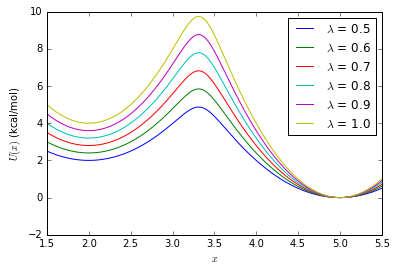

In [1]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

def U(x, kT=0.596):
    """Return the value of the 1D potential energy surface in kcal/mol:
    
    U(x) = -\frac{2k_BT}{0.596} \ln [ e^{-2(x-2)^2-2} + e^{-2(x-5)^2} ].      (1)
    
    PARAMS
    kT   - the thermal energy in units of kcal/mol 
    """
    return (-2.0*kT/0.596)*np.log( np.exp(-2.0*(x-2)**2 - 2) + np.exp(-2.0*(x-5)**2) )


dx = 0.01
xmin, xmax = 1.5, 5.5
x = np.arange(xmin, xmax+dx, dx)

plt.figure()
for lam in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot(x,lam*U(x),label='$\\lambda$ = %2.1f'%lam)
plt.xlabel('$x$')
plt.ylabel('$U(x)$ (kcal/mol)')
plt.xlim(xmin, xmax)
plt.legend(loc='best')
plt.show()

## A test data set

**Subsampling.** First, let's create a subsampled trajectory from the long 1e9-step trajectories that I sampled earlier.  The original trajectories are subsampled by stride 100 (1e7 steps).  Here, we will subsample again by stride 100, so the resulting trajectories will be 1e5 = 100000 in length.

**Choice of ensemble.** We will choose the set of trajectories simualted when the potential was scaled by $\lambda = 0.7$ trajectories.  There appear to be ample transitions to build good MSMs.

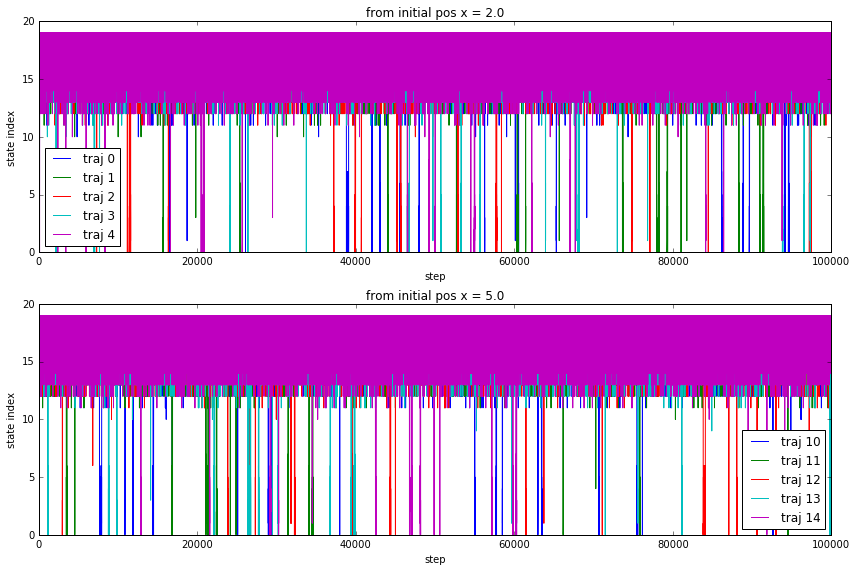

In [2]:
import os, sys

FilesAlreadyExist = True # False

ntrials = 10
lam = '0.7'

ntraj = 2*ntrials
# store all the discrete trajectories (of state indices) in 
dtrajs = []     # must be a list for oom;    not: np.zeros( (ntraj, 1e5) )

if not FilesAlreadyExist:
    wrkdir = "/Volumes/My2TBPassportUltra/projects/long_mcsampler"
    for initpos in ['2.0', '5.0']:
        for trial in range(ntrials):
            infile = os.path.join(wrkdir, 'nsteps1e9_init%s_lam%s_r%d.assignments.npy'%(initpos,lam,trial))
            print infile
            stride = 100
            assign = np.load(infile)[::stride]
            ## print assign.shape[0] #  should be 1.0e5

            outfile = 'subsampled-twostate-data/sub1e5_init%s_lam%s_r%d.assignments.npy'%(initpos,lam,trial)
            np.save(outfile, assign)

# Read in the subsampled trajectories
for initpos in ['2.0', '5.0']:
    for trial in range(ntrials):
        infile = 'subsampled-twostate-data/sub1e5_init%s_lam%s_r%d.assignments.npy'%(initpos,lam,trial) 
        dtrajs.append( np.load(infile) )
        
plt.figure(figsize=(12,8))

ntraces = 5
plt.subplot(2,1,1) 
plt.title('from initial pos x = 2.0')
for i in range(0,ntraces):
    plt.plot(dtrajs[i], label='traj '+str(i))
plt.xlabel('step')
plt.ylabel('state index')
plt.legend(loc='best')

plt.subplot(2,1,2) 
plt.title('from initial pos x = 5.0')
for i in range(ntraj/2,ntraj/2+ntraces):
    plt.plot(dtrajs[i], label='traj '+str(i))
plt.xlabel('step')
plt.ylabel('state index')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


## Does the code work?

Let's just try and build an OOM using PyEMMA, and see if it works.


In [3]:
from pyemma.msm.estimators import OOMReweightedMSM
from pyemma.msm import estimate_markov_model

import numpy as np

# Instantiate an OOM class
oom = OOMReweightedMSM(lag=1, reversible=True, count_mode='sliding',
                                  sparse=False, connectivity='largest', dt_traj='1 step',
                                  nbs=10000, rank_Ct='bootstrap_counts', tol_rank=10.0,
                                  score_method='VAMP2', score_k=10, mincount_connectivity='1/n')
# Try to perform an OOM estimation
try:
    oom.estimate(dtrajs)
    print 'Success!'
except:
    print 'Failure :('


Success!


/Users/vv/anaconda/lib/python2.7/site-packages/pyemma/__init__.py:134: UserWarning: Python 2.7 usage is deprecated. Future versions of PyEMMA will not support it. Please upgrade your Python installation.
  "Please upgrade your Python installation.", category=UserWarning)


According to my understanding, the OOM estimation is two-part:

### Corrected MSMs
* First, there a *corrected MSM* that is constructed from one- and two-step count matrices. The resulting MSM is a transition matrix and the object gives you as many eigenvalues/timescales as you want (e.g. the full neig=20).

### OOM timescales

* Second, there is are *OOM timescales* which are estimated.  These are calculated via a rank-*M* similarity transformation from the corrected MSM.  The higher the rank *M*, the better the approximation.

The OOM timescales are **NOT** affected by discretization errors, only finite sampling error, so if you have a lot of data, these timescales should be a better (slower!) reflection of the actual timescales.  However, they *ARE* affected by finite sampling error, which will affect the faster timescales (higher-rank OOM timescales) more than the slower ones.

So, to find out the value of the rank *M* that we should trust, the procedure is to do a bootstrap (drawing trajectories with replacement), and throw out all the faster timescales whose signal-to-noise ratio is less than a factor of tol_rank (the default is 10:1)

In [14]:
np.random.random_integers(0, high=19, size=20)

array([ 8,  6,  8,  1, 15,  5,  6, 14,  8,  6,  3, 11, 17, 13,  8, 10, 19,
       10,  8,  6])

In [15]:
## Let's build corrected MSMs and make an implied timescale plot

tau_values = [1,2,5,10,20,50,100,200]
ntimescales = 6
nboots = 5 # bootstrap trials
implied_timescales = np.zeros( (ntimescales, len(tau_values), nboots) )


for itau in range(len(tau_values)):
    tau = tau_values[itau]
    print 'Computing corrected MSM for tau =', tau, '...'

    # boot strap
    for iboot in range(nboots):
        oom = OOMReweightedMSM(lag=tau, reversible=True, count_mode='sliding',
                                  sparse=False, connectivity='largest', dt_traj='1 step',
                                  nbs=10000, rank_Ct='bootstrap_counts', tol_rank=10.0,
                                  score_method='VAMP2', score_k=10, mincount_connectivity='1/n')
        bootstrapped_dtraj = [dtrajs[i] for i in np.random.random_integers(0, high=19, size=nboots)]
        oom.estimate(bootstrapped_dtraj)
        implied_timescales[:,itau, iboot] = oom.timescales()[0:ntimescales]




Computing corrected MSM for tau = 1 ...
Computing corrected MSM for tau = 2 ...
Computing corrected MSM for tau = 5 ...
Computing corrected MSM for tau = 10 ...
Computing corrected MSM for tau = 20 ...
Computing corrected MSM for tau = 50 ...
Computing corrected MSM for tau = 100 ...
Computing corrected MSM for tau = 200 ...


implied_timescales.shape (6, 8, 5)
mean_implied_timescales.shape (6, 8)
std_implied_timescales.shape (6, 8)


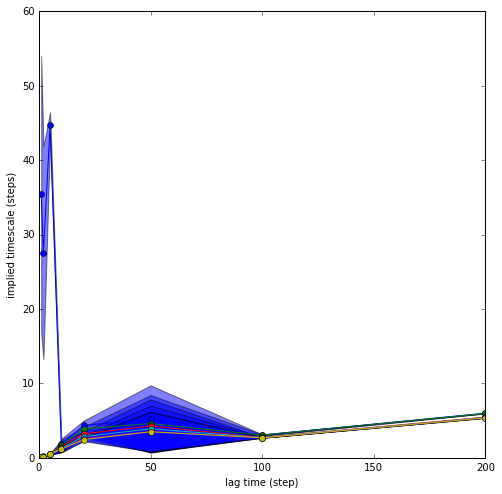

In [17]:
# Plot the results
mean_implied_timescales = implied_timescales.mean(axis=2)
std_implied_timescales = implied_timescales.std(axis=2)

# print implied_timescales

print 'implied_timescales.shape', implied_timescales.shape
print 'mean_implied_timescales.shape', mean_implied_timescales.shape
print 'std_implied_timescales.shape', std_implied_timescales.shape


# make implied timescales plot
plt.figure(figsize=(8,8))
for i in range(0,ntimescales):
    plt.plot(tau_values, mean_implied_timescales[i,:], 'o-')

    plt.fill_between(tau_values, mean_implied_timescales[i,:]+std_implied_timescales[i,:],
                     mean_implied_timescales[i,:]-std_implied_timescales[i,:], alpha=0.5)
    
plt.xlabel('lag time (step)')
plt.ylabel('implied timescale (steps)')
plt.show()



In [ ]:

    
the implied timescales as function print 'oom.timescales', oom.timescales()
print 'oom.timescales_OOM', oom.timescales_OOM

print oom.trajectory_weights()

print 'oom.OOM_components', oom.OOM_components
print 'oom.OOM_omega', oom.OOM_omega
print 'oom.OOM_rank', oom.OOM_rank
print 'oom.OOM_sigma', oom.OOM_sigma

params = oom.get_model_params() # dictionary of keys ['P', 'reversible', 'pi', 'dt_model', 'neig']
print params




In [ ]:

# let's check the stationary distribution to see how close we got
params = oom.get_model_params() # dictionary of keys ['P', 'reversible', 'pi', 'dt_model', 'neig']
pi = params['pi']  # stationary 
print pi

plt.figure()

# plot the true free energy surface
dx = 0.01
xmin, xmax = 1.5, 5.5
x = np.arange(xmin, xmax+dx, dx)
lam = 0.7
plt.plot(x, lam*U(x),label='true')  # in kcal/mol

# plot the estimated free energy surface
nstates = 20
bin_width = (xmax - xmin)/nstates
bin_edges = np.arange(xmin, xmax+bin_width, bin_width)
bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0
kT_in_kcal = 0.596
F = -0.596*np.log(pi)
F = F - F.min()
plt.plot(bin_centers, F, 'ro-', label='OOM estimate')
         
plt.xlim(xmin, xmax)
plt.ylabel('free energy (kcal/mol)')
plt.legend(loc='best')
plt.show()